<a href="https://colab.research.google.com/github/AndrewRucker/Fantasy-Football-and-Betting/blob/main/100_to_1st_SD_estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import data_table
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

lineups = pd.read_csv('https://raw.githubusercontent.com/AndrewRucker/Fantasy-Football-and-Betting/refs/heads/main/DFS/100_to_1st_sd_lineups/100_to_1st_winning_lineups_sd.csv')

In [ ]:
def optimal_structure_estimate(o_u, spread, lineups, o_u_range=10, spread_range=3.0):
    """
    Estimates 'total_salary', 'total_own', 'plays_fav', and 'plays_und' by averaging nearby values
    within specified ranges for 'o/u' and 'spread'. Calculates mean values and confidence intervals
    for numeric columns, and displays likelihoods of categorical columns including aggregated 'flex'
    values across f# columns.

    Parameters:
    - o_u (int or float): The over/under value.
    - spread (int or float): The spread value.
    - lineups (pd.DataFrame): The dataset containing lineup data.
    - o_u_range (float, optional): Range for filtering 'o/u' values (default is 10).
    - spread_range (float, optional): Range for filtering 'spread' values (default is 3.0).

    Returns:
    - dict: Dictionary with estimated mean values, confidence intervals, and likelihoods for categorical columns.
    """

    # Filter the dataset for rows within specified ranges
    nearby_rows = lineups[
        (lineups['o/u'].between(o_u - o_u_range, o_u + o_u_range)) &
        (lineups['spread'].between(spread - spread_range, spread + spread_range))
    ]

    # If no nearby rows found, return a message indicating lack of data
    if nearby_rows.empty:
        print("No nearby data points found. Adjust o_u_range or spread_range for more matches.")
        return {"message": "No nearby data points found. Adjust o_u_range or spread_range for more matches."}

    # Initialize a dictionary to store the mean and confidence intervals for numeric columns
    target_columns = ['total_salary', 'total_own', 'plays_fav', 'plays_und']
    estimates = {}

    # Set up the plotting space for numeric columns
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs = axs.flatten()  # Flatten the axes array for easy indexing

    # Calculate mean and standard deviation for each target column, plot distributions
    for i, col in enumerate(target_columns):
        mean_value = nearby_rows[col].mean()
        std_dev = nearby_rows[col].std()

        # Apply constraints based on known limits
        if col == 'total_salary':
            lower_bound = max(0, mean_value - std_dev)
            upper_bound = min(50000, mean_value + std_dev)
        elif col in ['plays_fav', 'plays_und']:
            lower_bound = max(0, mean_value - std_dev)
            upper_bound = min(5, mean_value + std_dev)
        else:
            lower_bound = mean_value - std_dev
            upper_bound = mean_value + std_dev

        # Store the estimates with confidence intervals
        estimates[col] = {
            'mean': mean_value,
            'confidence_interval': (lower_bound, upper_bound)
        }

        # Plotting the distribution of the data for this column
        axs[i].hist(nearby_rows[col], bins=10, color='skyblue', edgecolor='black')
        axs[i].axvline(mean_value, color='blue', linestyle='dashed', linewidth=2, label=f"Mean: {mean_value:.2f}")
        axs[i].axvline(lower_bound, color='red', linestyle='dotted', linewidth=2, label=f"Lower Bound: {lower_bound:.2f}")
        axs[i].axvline(upper_bound, color='green', linestyle='dotted', linewidth=2, label=f"Upper Bound: {upper_bound:.2f}")

        # Set title and labels
        axs[i].set_title(f'Distribution of {col}')
        axs[i].set_xlabel(col)
        axs[i].set_ylabel('Frequency')
        axs[i].legend()

    plt.tight_layout()
    plt.show()

    # Now process the categorical columns, including the 'flex' aggregation
    categorical_columns = ['cpt']
    likelihoods = {}

    fig, axs_cat = plt.subplots(1, 2, figsize=(15, 5))
    axs_cat = axs_cat.flatten()  # Flatten for easy indexing

    # Process 'cpt' individually
    value_counts_cpt = nearby_rows['cpt'].value_counts(normalize=True)
    likelihoods['cpt'] = value_counts_cpt.to_dict()

    # Plot the likelihood for 'cpt' column as a bar chart
    axs_cat[0].bar(value_counts_cpt.index, value_counts_cpt.values, color='lightcoral', edgecolor='black')
    axs_cat[0].set_title('Likelihood of cpt')
    axs_cat[0].set_xlabel('cpt')
    axs_cat[0].set_ylabel('Probability')

    # Aggregate all values from f1 to f5 columns as "flex"
    flex_values = nearby_rows[['f1', 'f2', 'f3', 'f4', 'f5']].values.flatten()
    flex_counts = pd.Series(flex_values).value_counts(normalize=True)
    likelihoods['flex'] = flex_counts.to_dict()

    # Plot the likelihood for 'flex' as a bar chart
    axs_cat[1].bar(flex_counts.index, flex_counts.values, color='lightblue', edgecolor='black')
    axs_cat[1].set_title('Likelihood of Flex (f# columns)')
    axs_cat[1].set_xlabel('Flex')
    axs_cat[1].set_ylabel('Probability')

    plt.tight_layout()
    plt.show()

    # Calculate common combinations of values across f# columns for relationship analysis
    flex_combinations = nearby_rows[['f1', 'f2', 'f3', 'f4', 'f5']].apply(lambda row: tuple(sorted(row)), axis=1)
    combination_counts = flex_combinations.value_counts(normalize=True).head(10)
    likelihoods['flex_combinations'] = combination_counts.to_dict()

    # Return the estimates for numeric columns and likelihoods for categorical columns
    return {
        'numeric_estimates': estimates,
        'categorical_likelihoods': likelihoods
    }

# Example usage with the lineups DataFrame
# result = optimal_structure_estimate(45.5, 8.5, lineups)
# print(result)

In [ ]:
def optimal_structure_estimate_with_cpt(o_u, spread, lineups, o_u_range=10, spread_range=3.0, specific_cpt=None):
    """
    Estimates 'total_salary', 'total_own', 'plays_fav', and 'plays_und' by averaging nearby values
    within specified ranges for 'o/u' and 'spread'. Calculates mean values and confidence intervals
    for numeric columns. If a specific 'cpt' value is provided, outputs the most likely values in
    'flex' columns when that 'cpt' is present, along with a visual.

    Parameters:
    - o_u (int or float): The over/under value.
    - spread (int or float): The spread value.
    - lineups (pd.DataFrame): The dataset containing lineup data.
    - o_u_range (float, optional): Range for filtering 'o/u' values (default is 10).
    - spread_range (float, optional): Range for filtering 'spread' values (default is 3.0).
    - specific_cpt (str, optional): A specific value in the 'cpt' column to filter by.

    Returns:
    - dict: Dictionary with estimated mean values, confidence intervals, and likelihoods for categorical columns.
    """

    # Filter the dataset for rows within specified ranges
    nearby_rows = lineups[
        (lineups['o/u'].between(o_u - o_u_range, o_u + o_u_range)) &
        (lineups['spread'].between(spread - spread_range, spread + spread_range))
    ]

    # If no nearby rows found, return a message indicating lack of data
    if nearby_rows.empty:
        print("No nearby data points found. Adjust o_u_range or spread_range for more matches.")
        return {"message": "No nearby data points found. Adjust o_u_range or spread_range for more matches."}

    # Initialize a dictionary to store the mean and confidence intervals for numeric columns
    target_columns = ['total_salary', 'total_own', 'plays_fav', 'plays_und']
    estimates = {}

    # Set up the plotting space for numeric columns
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    axs = axs.flatten()  # Flatten the axes array for easy indexing

    # Calculate mean and standard deviation for each target column, plot distributions
    for i, col in enumerate(target_columns):
        mean_value = nearby_rows[col].mean()
        std_dev = nearby_rows[col].std()

        # Apply constraints based on known limits
        if col == 'total_salary':
            lower_bound = max(0, mean_value - std_dev)
            upper_bound = min(50000, mean_value + std_dev)
        elif col in ['plays_fav', 'plays_und']:
            lower_bound = max(0, mean_value - std_dev)
            upper_bound = min(5, mean_value + std_dev)
        else:
            lower_bound = mean_value - std_dev
            upper_bound = mean_value + std_dev

        # Store the estimates with confidence intervals
        estimates[col] = {
            'mean': mean_value,
            'confidence_interval': (lower_bound, upper_bound)
        }

        # Plotting the distribution of the data for this column
        axs[i].hist(nearby_rows[col], bins=10, color='skyblue', edgecolor='black')
        axs[i].axvline(mean_value, color='blue', linestyle='dashed', linewidth=2, label=f"Mean: {mean_value:.2f}")
        axs[i].axvline(lower_bound, color='red', linestyle='dotted', linewidth=2, label=f"Lower Bound: {lower_bound:.2f}")
        axs[i].axvline(upper_bound, color='green', linestyle='dotted', linewidth=2, label=f"Upper Bound: {upper_bound:.2f}")

        # Set title and labels
        axs[i].set_title(f'Distribution of {col}')
        axs[i].set_xlabel(col)
        axs[i].set_ylabel('Frequency')
        axs[i].legend()

    plt.tight_layout()
    plt.show()

    # Dictionary to store likelihoods for specific flex combinations when specific_cpt is provided
    likelihoods = {}

    # Calculate common combinations of values across f# columns for relationship analysis
    flex_combinations = nearby_rows[['f1', 'f2', 'f3', 'f4', 'f5']].apply(lambda row: tuple(sorted(row)), axis=1)
    combination_counts = flex_combinations.value_counts(normalize=True).head(10)
    likelihoods['flex_combinations'] = combination_counts.to_dict()

    # If a specific CPT is provided, find the most likely values in f# columns
    if specific_cpt:
        specific_cpt_rows = nearby_rows[nearby_rows['cpt'] == specific_cpt]

        if not specific_cpt_rows.empty:
            # Concatenate f# column values into a single Series and calculate the value counts
            specific_flex_values = specific_cpt_rows[['f1', 'f2', 'f3', 'f4', 'f5']].values.flatten()
            specific_flex_counts = pd.Series(specific_flex_values).value_counts(normalize=True)
            likelihoods['specific_flex'] = specific_flex_counts.to_dict()

            # Plot the distribution of the specific flex values when cpt is specified
            plt.figure(figsize=(10, 6))
            specific_flex_counts.plot(kind='bar', color='cornflowerblue', edgecolor='black')
            plt.title(f'Likelihood of Values in Flex Columns when CPT is {specific_cpt}')
            plt.xlabel('Flex Values')
            plt.ylabel('Likelihood')
            plt.xticks(rotation=45)
            plt.show()

        else:
            likelihoods['specific_flex'] = {}
            print(f"No rows found for specific cpt: {specific_cpt}")

    # Return the estimates for numeric columns and likelihoods for categorical columns
    return {
        'numeric_estimates': estimates,
        'categorical_likelihoods': likelihoods
    }

# Example usage with the lineups DataFrame
# result = optimal_structure_estimate_with_cpt(45.5, 8.5, lineups, specific_cpt='fav_wr')
# print(result)

In [ ]:
# Convert 'cpt_own' and 'total_own' columns to numeric types
lineups['cpt_own'] = pd.to_numeric(lineups['cpt_own'], errors='coerce')
lineups['total_own'] = pd.to_numeric(lineups['total_own'], errors='coerce')

# Check if the conversion succeeded and if any nulls were introduced
print(lineups[['cpt_own', 'total_own']].isnull().sum())

# If there are any null values, decide to fill or drop
lineups.dropna(subset=['cpt_own', 'total_own'], inplace=True)


cpt_own      0
total_own    0
dtype: int64


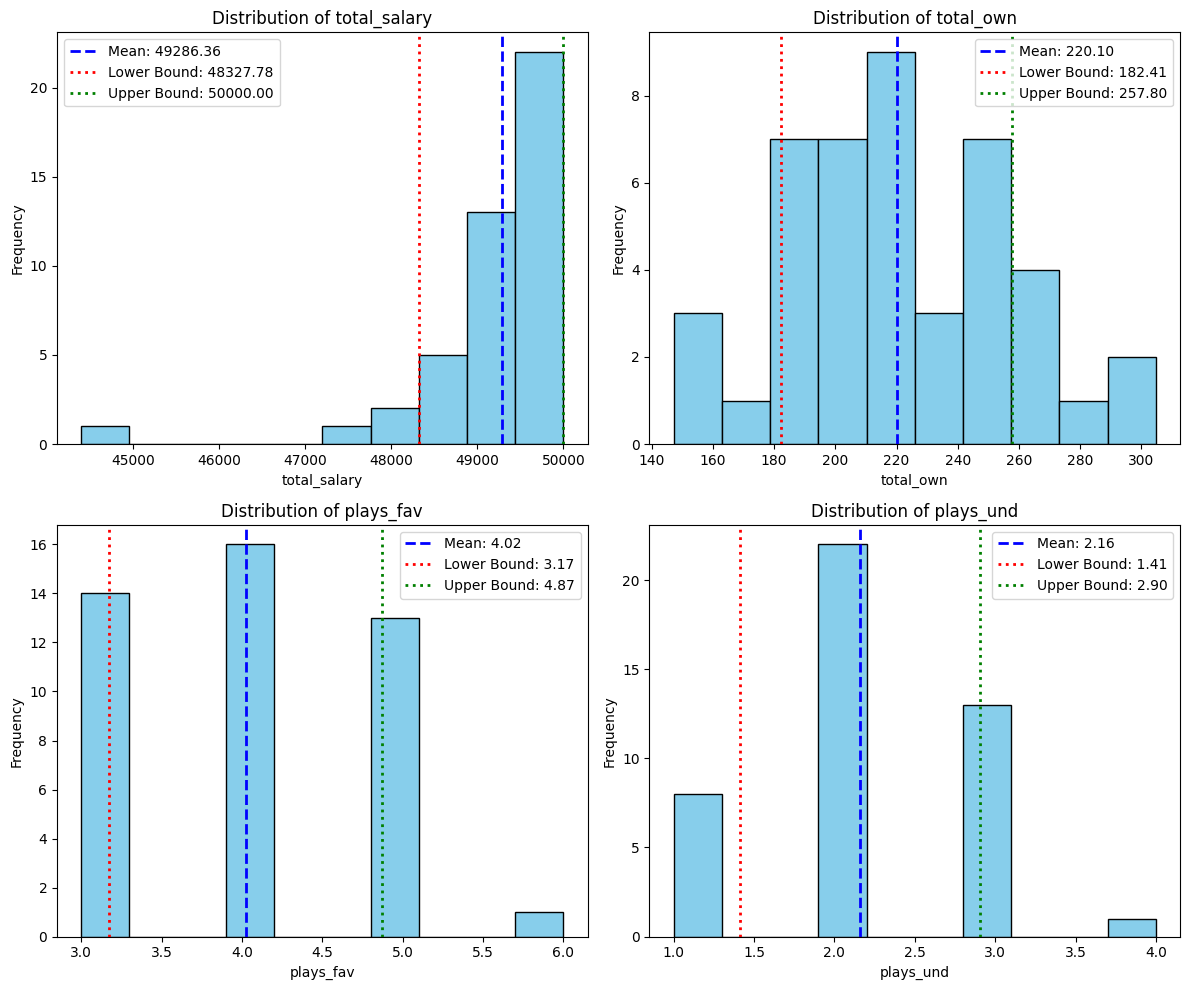

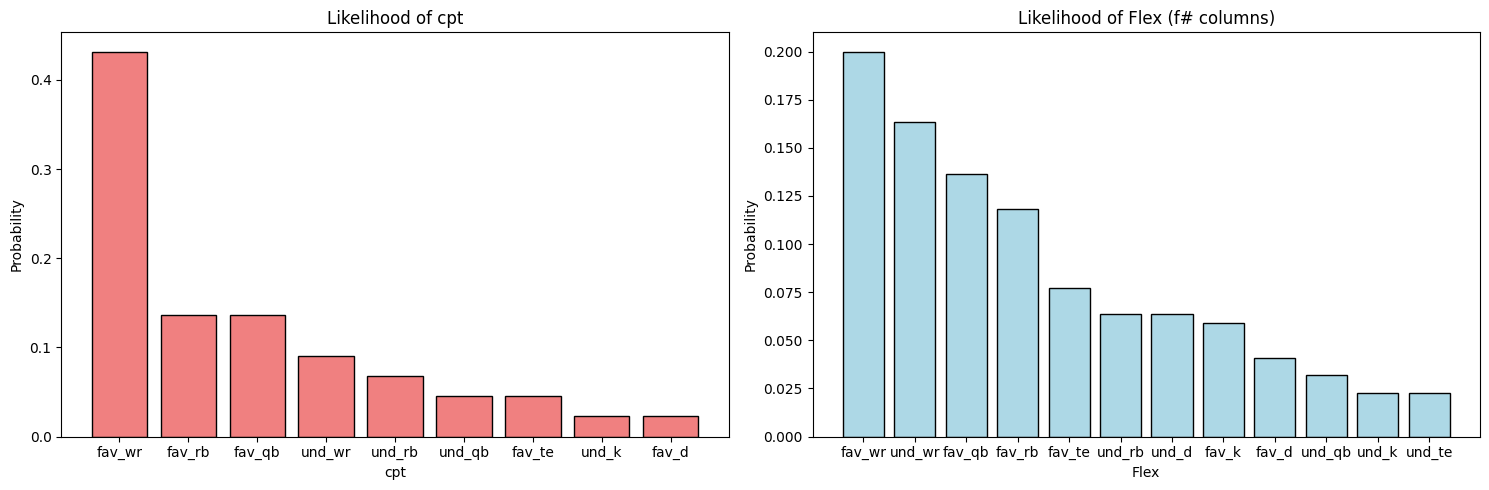

{'numeric_estimates': {'total_salary': {'mean': 49286.36363636364,
   'confidence_interval': (48327.78161452074, 50000)},
  'total_own': {'mean': 220.10454545454542,
   'confidence_interval': (182.41351910568562, 257.7955718034052)},
  'plays_fav': {'mean': 4.0227272727272725,
   'confidence_interval': (3.173962469420771, 4.871492076033774)},
  'plays_und': {'mean': 2.159090909090909,
   'confidence_interval': (1.4137743127691564, 2.904407505412662)}},
 'categorical_likelihoods': {'cpt': {'fav_wr': 0.4318181818181818,
   'fav_rb': 0.13636363636363635,
   'fav_qb': 0.13636363636363635,
   'und_wr': 0.09090909090909091,
   'und_rb': 0.06818181818181818,
   'und_qb': 0.045454545454545456,
   'fav_te': 0.045454545454545456,
   'und_k': 0.022727272727272728,
   'fav_d': 0.022727272727272728},
  'flex': {'fav_wr': 0.2,
   'und_wr': 0.16363636363636364,
   'fav_qb': 0.13636363636363635,
   'fav_rb': 0.11818181818181818,
   'fav_te': 0.07727272727272727,
   'und_rb': 0.06363636363636363,
   'u

In [ ]:
optimal_structure_estimate(41, 7, lineups)

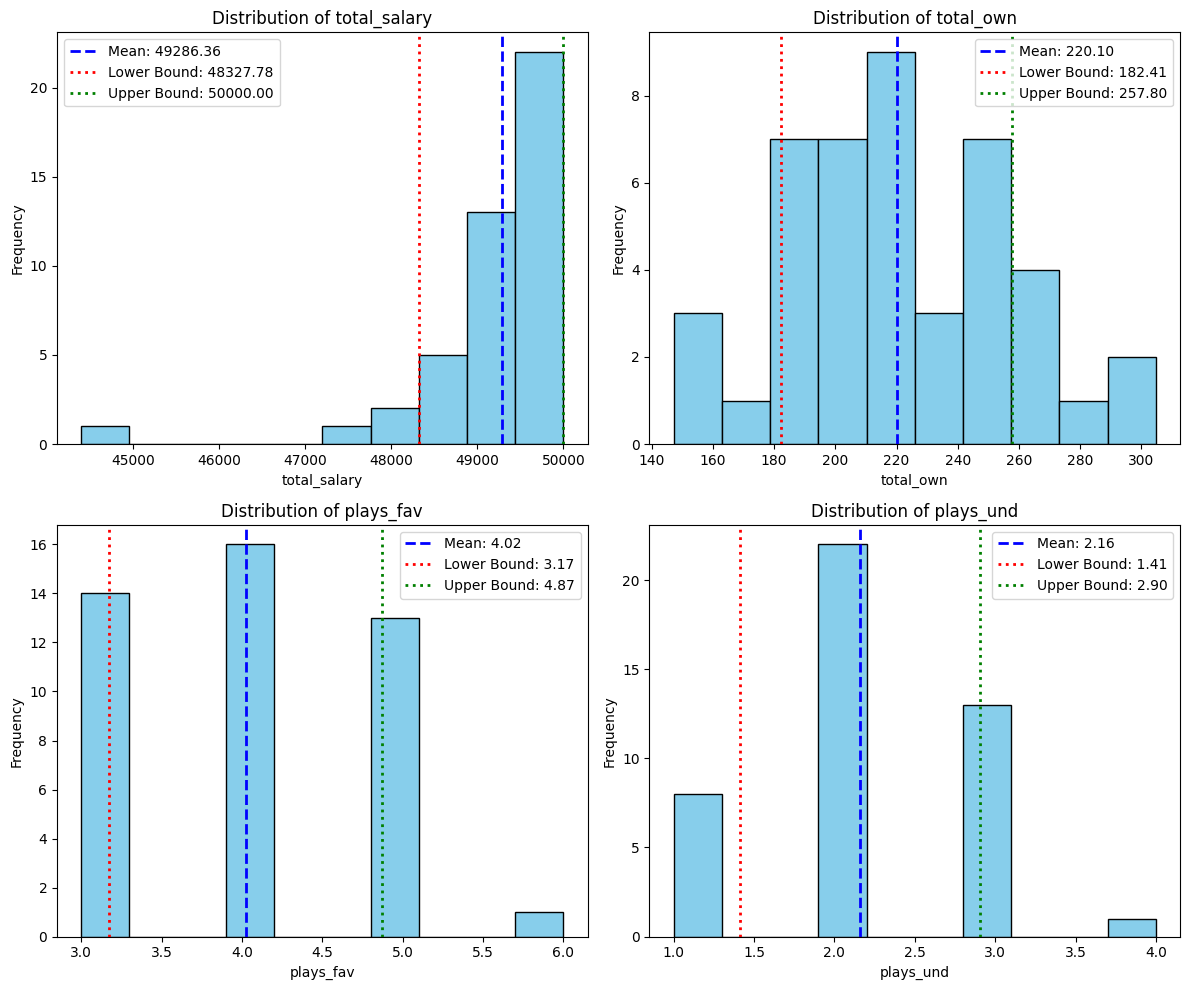

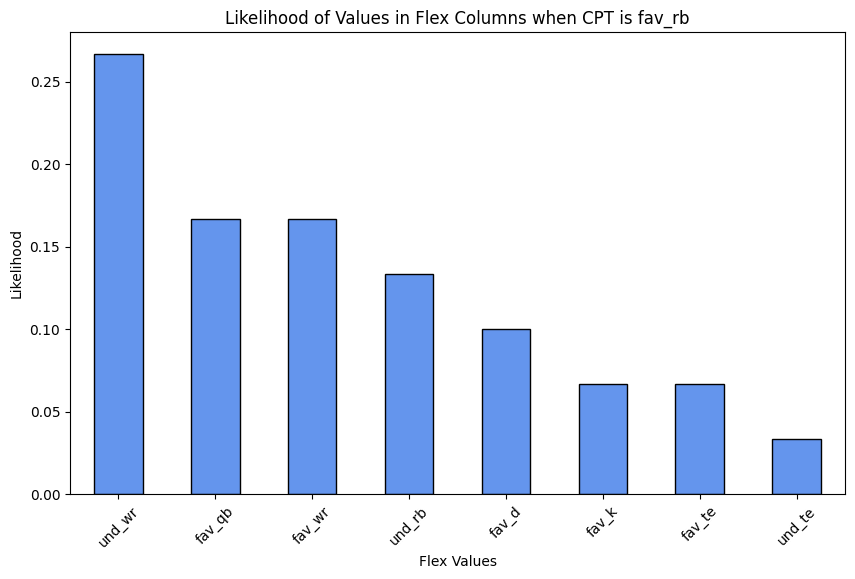

{'numeric_estimates': {'total_salary': {'mean': 49286.36363636364,
   'confidence_interval': (48327.78161452074, 50000)},
  'total_own': {'mean': 220.10454545454542,
   'confidence_interval': (182.41351910568562, 257.7955718034052)},
  'plays_fav': {'mean': 4.0227272727272725,
   'confidence_interval': (3.173962469420771, 4.871492076033774)},
  'plays_und': {'mean': 2.159090909090909,
   'confidence_interval': (1.4137743127691564, 2.904407505412662)}},
 'categorical_likelihoods': {'flex_combinations': {('fav_qb',
    'fav_wr',
    'und_d',
    'und_k',
    'und_wr'): 0.06818181818181818,
   ('fav_qb', 'fav_rb', 'fav_wr', 'und_d', 'und_wr'): 0.045454545454545456,
   ('fav_k', 'fav_rb', 'fav_te', 'fav_wr', 'und_wr'): 0.045454545454545456,
   ('fav_rb', 'fav_wr', 'und_qb', 'und_rb', 'und_wr'): 0.045454545454545456,
   ('fav_qb', 'fav_te', 'fav_wr', 'fav_wr', 'und_wr'): 0.022727272727272728,
   ('fav_rb', 'fav_te', 'fav_wr', 'fav_wr', 'und_wr'): 0.022727272727272728,
   ('fav_rb', 'fav_wr'

In [ ]:
optimal_structure_estimate_with_cpt(41, 7, lineups, specific_cpt='fav_rb')